In [ ]:
## Actor Critic Model - testing on the half cheetah environment

## Try to implement Proximal Policy Optimisation

# The model used code from: https://github.com/pythonlessons/Reinforcement_Learning/blob/master/BipedalWalker-v3_PPO/BipedalWalker-v3_PPO.py

In [2]:
###### IMPORTANT: In order for mujoco to work must run it from the command line, i.e. jupyter lab 

#############################################################################################
import gym
import pickle
import tensorflow as tf 
import numpy as np
import math
import imageio
import copy
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow import random_normal_initializer
from tensorflow.keras import backend as K

#############################################################################################

### SANITY CHECK ### 

# ENVIRONMENT SUMMARY: -> LunarLanderContinuous-v2
# -> Continuous action space

# Observation -> 8 items
# These correspond to the position (x,y), velocity (x,y), angular velocity, angle and whether legs are in zone

# Action -> 2 items
# Value for main engine thrust and side engine thrust

# Reward -> 1 item
# Reward for moving from the top of the screen to the landing pad and zero speed is about 100..140 points.
# If the lander moves away from the landing pad it loses reward. The episode finishes if the lander crashes or
# comes to rest, receiving an additional -100 or +100 points. Each leg with ground contact is +10 points.
# Firing the main engine is -0.3 points each frame. Firing the side engine is -0.03 points each frame.
# Solved is 200 points.

### MAIN ###

# ENVIRONMENT SUMMARY: -> Half Cheetah
# -> Continuous action space

# Observation -> 17 items
# These correspond to the position, angle and speed of the joints

# Action -> 6 items
# These correspond to 6 actuators in the cheetah 
# Value specifies the torque

# Reward -> 1 item
# Reward is proportional to the velocity of the cheetah
# Reward is subtracted by a ctrl cost which I think is proportional to the applied torque.

############################################################################################
# NOTES

# HYPERPARAMETERS
# Learning rate appears pretty optimum from graph
# Could also select lambda for GAE and gamma. 
# The std at the moment is a constant, but could be lowered to increase model exploitation

############################################################################################

# VARIABLES:
NB_FRAMES = 10_000
TOTAL_EPISODES = 3_000
SAVE_FREQUENCY = 1_000
RENDER = True

##########################################################################################

# FUNCTIONS

# learns what action to take under a particular observed state of the environment
class Actor_Model:
    def __init__(self, input_shape, lr, optimizer, action_space):
        X_input = Input(input_shape)
        self.action_space = action_space
        
        X = Dense(512, activation="relu", kernel_initializer=random_normal_initializer(stddev=0.01))(X_input)
        X = Dense(256, activation="relu", kernel_initializer=random_normal_initializer(stddev=0.01))(X)
        X = Dense(64, activation="relu", kernel_initializer=random_normal_initializer(stddev=0.01))(X)
        output = Dense(self.action_space, activation="tanh")(X)

        self.Actor = Model(inputs = X_input, outputs = output)
        self.Actor.compile(loss=self.ppo_loss_continuous, optimizer=optimizer(lr=lr))
    
    # Implementation of PPO clip 
    # relies on specialized clipping in the objective function to remove incentives for the new policy to get far from the old policy.
    def ppo_loss_continuous(self, y_true, y_pred):
        
        # returns the advantage functions
        advantages = y_true[:, :1]
        
        # returns the actions 
        actions = y_true[:, 1:1 + self.action_space]
        
        # returns the old policy
        logp_old_ph = y_true[:, 1 + self.action_space]
        
        # defines the loss clipping
        LOSS_CLIPPING = 0.2
        
        # get the policy
        logp = self.gaussian_likelihood(actions, y_pred)
        
        # gives policy/old policy
        ratio = tf.math.exp(logp - logp_old_ph)
        
        # 1st term in loss function
        p1 = ratio * advantages
        
        # 2nd term in the loss function 
        # returns 1 + clip if advantage +ve and 1 - clip otherwise
        p2 = tf.where(advantages > 0, (1.0 + LOSS_CLIPPING) * advantages, (1.0 - LOSS_CLIPPING) * advantages)
        
        # calculates the minimum
        actor_loss = -tf.math.reduce_mean(tf.math.minimum(p1, p2))

        return actor_loss
    
    # maximises the likelihood of data givent the model
    def gaussian_likelihood(self, actions, pred):
        
        # creates an array of -0.5 equal to action space
        log_std = -0.5 * tf.ones(self.action_space, dtype=tf.float32)
        
        # the equation for log likliehood
        pre_sum = -0.5 * (((actions - pred)/(tf.math.exp(log_std) + 1e-8)) ** 2 + 2 * log_std + tf.math.log(2 * tf.constant(math.pi)))
        
        # sum all the values
        return tf.math.reduce_sum(pre_sum, axis=1)

    def predict(self, state):
        return self.Actor(state)
    
# evaluates if the action taken by the Actor led our environment to be in a better state or not    
class Critic_Model:
    def __init__(self, input_shape, lr, optimizer):
        X_input = Input(shape=(input_shape,))

        V = Dense(512, activation="relu", kernel_initializer=random_normal_initializer(stddev=0.01))(X_input)
        V = Dense(256, activation="relu", kernel_initializer=random_normal_initializer(stddev=0.01))(V)
        V = Dense(64, activation="relu", kernel_initializer=random_normal_initializer(stddev=0.01))(V)
        value = Dense(1, activation=None)(V)

        self.Critic = Model(inputs=[X_input], outputs=[value])
        self.Critic.compile(loss=[self.critic_PPO2_loss()], optimizer=optimizer(lr=lr))        
    
    # mean squared error with clipping implemented
    def critic_PPO2_loss(self):
        def loss(y_true, y_pred):
            
            value_loss= K.mean((y_true - y_pred) ** 2)             
            
            return value_loss
        return loss    

    def predict(self, state):
        return self.Critic([state, np.zeros((state.shape[0], 1))])
    
class PPOAgent:
    def __init__(self, lr, action_space, state_space, batch):
        
        # Define the environment
        self.lr = lr
        self.batch = batch 
        self.epochs = 10 
        self.shuffle = True
        self.optimizer = Adam
        self.action_space = action_space
        self.state_space = state_space

        # Create Actor-Critic network models
        self.Actor = Actor_Model(input_shape = self.state_space, lr=self.lr, optimizer = self.optimizer, action_space = self.action_space)
        self.Critic = Critic_Model(input_shape = self.state_space, lr=self.lr, optimizer = self.optimizer)

        # Defining log_std
        self.log_std = -0.5 * tf.ones(self.action_space, dtype=tf.float32)
        self.std = tf.math.exp(self.log_std)

    # defines how the model should act
    def act(self, state):
        
        # defines the action to take 
        pred = self.Actor.predict(state)

        low, high = -1.0, 1.0 
        
        # adds some randomness to the predicted mean
        action = pred + np.random.uniform(low, high, size=pred.shape) * self.std
        
        # ensures value doesn't exceed the range
        action = np.clip(action, low, high)
        
        # return the log policy
        logp_t = self.gaussian_likelihood(action, pred, self.log_std)

        return action, logp_t
    
    # same as above
    def gaussian_likelihood(self, action, pred, log_std):
        pre_sum = -0.5 * (((action - pred)/(np.exp(log_std) + 1e-8)) **2  + 2 * log_std + np.log(2 * np.pi)) 
        return np.sum(pre_sum, axis=1)
    
    # generalised advantage estimation
    # how much of an advantage was obtained by taking the chosen action 
    # provides a weighting to the advantage function
    def get_gaes(self, rewards, dones, values, next_values, gamma = 0.99, lamda = 0.90):
        
        # calculates the deltas for the GAEs formula
        # if done = 1 -> no nv, stops an error appearing
        deltas = [r + gamma * (1 - d) * nv - v for r, d, nv, v in zip(rewards, dones, next_values, values)]
        deltas = np.stack(deltas)
        
        # creates a copy of the deltas
        gaes = copy.deepcopy(deltas)
        
        # iterates through the gaes to include reward-to-go
        for t in reversed(range(len(deltas) - 1)):
            gaes[t] = gaes[t] + (1 - dones[t]) * gamma * lamda * gaes[t + 1]

        # calculates the targets 
        target = gaes + values
        
        # normalisation
        gaes = (gaes - gaes.mean()) / (gaes.std() + 1e-8)
            
        return np.vstack(gaes), np.vstack(target)   
    
    
    def replay(self, states, actions, rewards, dones, next_states, logp_ts):
        
        states = np.vstack(states)
        next_states = np.vstack(next_states)
        actions = np.vstack(actions)
        logp_ts = np.vstack(logp_ts)

        # Get Critic Predictions 
        values = self.Critic.predict(states)
        next_values = self.Critic.predict(next_states)

        # Compute discounted rewards and advantages
        advantages, target = self.get_gaes(rewards, dones, np.squeeze(values), np.squeeze(next_values))
        
        # Pack all advantages, predictions and actions to y_true and when they are received
        y_true = np.hstack([advantages, actions, logp_ts])
        
        # Training Actor and Critic
        a_loss = self.Actor.Actor.fit(states, y_true, epochs=self.epochs, verbose=0, shuffle=self.shuffle, batch_size=self.batch)    
        c_loss = self.Critic.Critic.fit(states, target, epochs=self.epochs, verbose=0, shuffle=self.shuffle, batch_size=self.batch)
        
    def load(self):
        self.Actor.Actor.load_weights('./Models/Actor_model_4000ep.h5')
        self.Critic.Critic.load_weights('./Models/Critic_model_4000ep.h5')

    def save(self, name):
        #self.Actor.Actor.save_weights('./Models/Actor_model' + str(name) +  '.h5')
        #self.Critic.Critic.save_weights('./Models/Critic_model' + str(name) +  '.h5')
        pass


#######################################################################################

state_space = 17
action_space = 6
# learning_rate = 0.00025 -> LunarLander
# learning_rate = 7.5e-5 -> Cheetah
# lambda no different from 0.9 -> 0.95
# batch -> deteriorates following 64

batch = 32
learn_rate = 0.000075

# intitialise the environment
env = gym.make('HalfCheetah-v3')
# env = gym.make('LunarLanderContinuous-v2')
s = env.reset()
s = np.reshape(s, [1, state_space])
total_score = []

# stores frames to make a .gif
# frames = []

agent = PPOAgent(learn_rate, action_space, state_space, batch)
agent.load()

for e in range(1, TOTAL_EPISODES + 1):

    print('Starting Episode {}'.format(e)) 

    # intialise the memory 
    score = 0
    states, next_states, actions, rewards, dones, logp_ts = [], [], [], [], [], []

    for f in range(NB_FRAMES):

        # render the environment
        if RENDER:            
            env.render()

            # for saving gif files            
            # if e > 1:
            #     frames.append(env.render(mode = 'rgb_array'))   

        # select the action
        a, logp_t = agent.act(s)

        # perform action
        s1, r, done, _ = env.step(a[0]) 

        # add to memory        
        states.append(s)
        next_states.append(np.reshape(s1, [1, state_space]))
        actions.append(a)
        rewards.append(r)
        dones.append(done)
        logp_ts.append(logp_t[0])

        # update the current state
        s = np.reshape(s1, [1, state_space])
        score += r

        # when episode ends
        if done:

            s = env.reset() 
            s = np.reshape(s, [1, state_space])   

            total_score.append(score)

            print('The score at the end of episode {} is: {}'.format(e, score))           

            if e % SAVE_FREQUENCY == 0:
                with open("./Reward_Files/rewards-ep-" + str(e) + ".txt", "wb") as file:
                    pickle.dump(total_score, file)   

                agent.save('')

            break

    # add to memory buffer
    agent.replay(states, actions, rewards, dones, next_states, logp_ts)

# close the environment
env.close()

# for saving gif files
#imageio.mimsave('./Images/AC_Lunar.gif', frames, fps=30)


Starting Episode 1
Creating window glfw
The score at the end of episode 1 is: 2950.8250603249494
Starting Episode 2
The score at the end of episode 2 is: 2844.820177445296
Starting Episode 3
The score at the end of episode 3 is: 2808.66514357486
Starting Episode 4
The score at the end of episode 4 is: 2741.0129850704598
Starting Episode 5
The score at the end of episode 5 is: 532.9125596204118
Starting Episode 6


SystemExit: 0

/home/hemerson/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2971: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


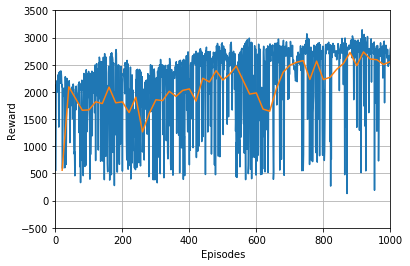

In [7]:
import matplotlib.pyplot as plt

with open("./Reward_Files/rewards-ep-3000.txt", "rb") as file:
    a = pickle.load(file)    
    
mean = []
tally = []

for i in range(len(a)):    
    
    tally.append(a[i])    
    
    if i % 20 == 0:
        mean_v = np.mean(tally)
        mean.append(mean_v)
        tally = []
        
    
x1 = np.array(range(1,151)) * 20
y1 = mean
x2 = np.array(range(1, 3001))
y2 = a

plt.plot(x2,y2)
plt.plot(x1,y1)
plt.xlim(0, 1000)
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.ylim(-500, 3500)
plt.grid(alpha=1.0)

# plt.savefig('./Images/AC_Lunar_5000ep.png')

plt.show()
    

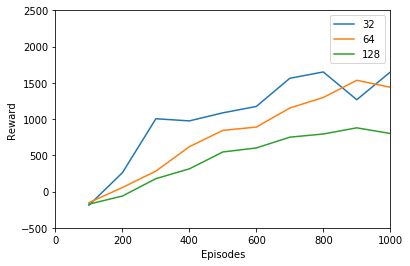

In [18]:
import matplotlib.pyplot as plt
import pickle

with open("./Reward_Files/rewards-ep-1000-lr-7.5e-05.txt", "rb") as file:
    a = pickle.load(file)    
    
with open("./Reward_Files/rewards-ep-1000-batch-64.txt", "rb") as file:
    b = pickle.load(file)    

with open("./Reward_Files/rewards-ep-1000-batch-128.txt", "rb") as file:
    c = pickle.load(file)    
"""  
with open("./Reward_Files/rewards-ep-1000-lr-7.5e-05.txt", "rb") as file:
    d = pickle.load(file)    
    
with open("./Reward_Files/rewards-ep-1000-lr-7.5e-06.txt", "rb") as file:
    e = pickle.load(file) 
"""
    
    
a_m = []
b_m = []
c_m = []
"""d_m = []
e_m = []"""

a_t = []
b_t = []
c_t = []
"""d_t = []
e_t = []"""

    
for i in range(len(a)):    
    
    a_t.append(a[i])    
    b_t.append(b[i])    
    c_t.append(c[i])    
    """d_t.append(d[i])    
    e_t.append(e[i])    """
    
    if i % 100 == 0:
        a_mean = np.mean(a_t)
        a_m.append(a_mean)
        
        b_mean = np.mean(b_t)
        b_m.append(b_mean)
        
        c_mean = np.mean(c_t)
        c_m.append(c_mean)
        """
        d_mean = np.mean(d_t)
        d_m.append(d_mean)
        
        e_mean = np.mean(e_t)
        e_m.append(e_mean)  """
        
        a_t = []
        b_t = []
        c_t = []
        """d_t = []
        e_t = []  """
    

x = np.array(range(1,11)) * 100

plt.plot(x, a_m)
plt.plot(x, b_m)
plt.plot(x, c_m)
"""plt.plot(x, d_m)
plt.plot(x, e_m)"""

plt.xlabel('Episodes')
plt.ylabel('Reward')


plt.legend(('32','64', '128'))
plt.xlim(0, 1000)
plt.ylim(-500, 2500)
plt.show()

#plt.savefig('./Images/Cheetah_1000ep-batch_comp.png')
